In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from math import sin, cos, pi

def rot(ev, theta):
    R = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return np.dot(np.dot(R, np.diag(ev)), R.T)

Fisher's determinant
---

Here we use Fisher's determinant to separate two Gaussian clusters of data.

In [4]:
sigma1 = rot([0.5, 0.1], pi/4)
sigma2 = rot([0.6, 0.2], pi/2)
mu1 = np.array([1.0, 0.0])
mu2 = np.array([-1.0, 1.0])

In [5]:
samples1 = np.random.multivariate_normal(mu1, sigma1, 100)
samples2 = np.random.multivariate_normal(mu2, sigma2, 100)

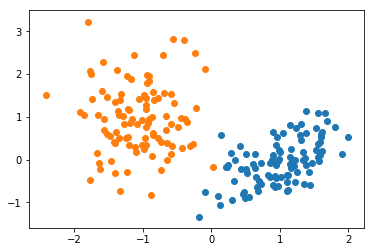

In [6]:
plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

In [7]:
xs = np.linspace(-2, 2, 100)
ys = np.linspace(-2, 3, 100)
X, Y = np.meshgrid(xs, ys)
XY = np.stack([X, Y], axis=-1)

In [8]:
d1 = XY - mu1
d2 = XY - mu2
prec1 = np.linalg.pinv(sigma1)
prec2 = np.linalg.pinv(sigma2)
f = np.log(np.linalg.det(sigma2)/np.linalg.det(sigma1))

fisher = (
    0.5 * np.einsum("ijk, kl, ijl -> ij", d1, prec1, d1) - 
    0.5 * np.einsum("ijk, kl, ijl -> ij", d2, prec2, d2) + f
)

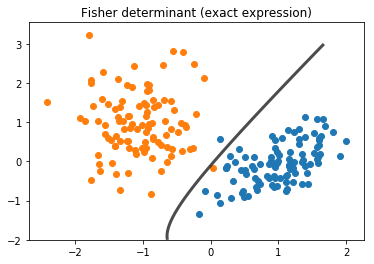

In [9]:
plt.contour(X, Y, fisher, [0], colors='k', linewidths=3, alpha=0.7)

plt.scatter(*samples1.T)
plt.scatter(*samples2.T)
plt.title("Fisher determinant (exact expression)");

In [10]:
sigma = (sigma1 + sigma2) / 2
prec = np.linalg.pinv(sigma)

fisher_linear = (
    np.einsum("i,ij,klj", mu1 - mu2, prec, XY)
    - 0.5 * (np.dot(mu1, np.dot(prec, mu1)) - np.dot(mu2, np.dot(prec, mu2)))
)

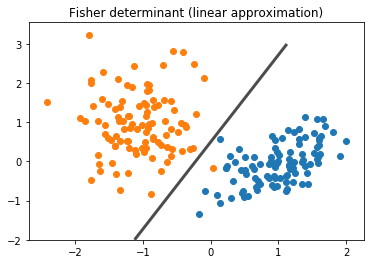

In [11]:
plt.contour(X, Y, fisher_linear, [0], colors='k', linewidths=3, alpha=0.7)

plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

plt.title("Fisher determinant (linear approximation)");

Linearly separable clusters, SVM
---

In [44]:
mu1 = np.array([-3.0, -2.5])
mu20 = np.array([-1.0, 1.5])
mu21 = np.array([1.2, -2.0])
sigma1 = rot([0.5, 0.5], 0)
sigma20 = rot([0.8, 0.2], 0)
sigma21 = rot([0.2, 0.8], 0)

samples1 = np.random.multivariate_normal(mu1, sigma1, 20)
samples20 = np.random.multivariate_normal(mu20, sigma20, 10)
samples21 = np.random.multivariate_normal(mu21, sigma21, 10)
samples2 = np.vstack([samples20, samples21])

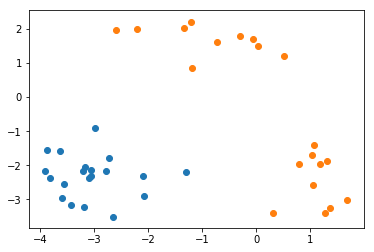

In [45]:
plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

In [105]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm

gamma = 0.1

points = np.vstack([samples1, samples2])

n = samples1.shape[0]
dist = pdist(points)
#kernel = squareform(np.exp(-dist ** 2 / (2*gamma**2)))
 
kernel = np.empty((2*n, 2*n), dtype=float)
for i in range(2*n):
    for j in range(2*n):
        kernel[i, j] = np.dot(points[i], points[j])
    
signs = np.array(n*[1] + n*[-1])
signed_kernel = kernel * np.outer(signs, signs)

In [106]:
import cvxopt

In [107]:
N = 2*n

P = cvxopt.matrix(signed_kernel)
q = cvxopt.matrix(-np.ones(N), tc='d')
G = cvxopt.matrix(-np.eye(N), tc='d')
h = cvxopt.matrix(np.zeros(N), tc='d')
A = cvxopt.matrix(signs[np.newaxis, :], tc='d')
b = cvxopt.matrix([0], tc='d')

In [108]:
sol = cvxopt.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -4.1932e+00 -8.2534e+00  1e+02  9e+00  2e+00
 1: -7.5742e+00 -6.1023e+00  4e+01  3e+00  6e-01
 2: -1.8057e+01 -9.1366e+00  2e+01  2e+00  4e-01
 3: -2.0647e+00 -3.4055e+00  3e+00  5e-02  1e-02
 4: -2.7613e+00 -2.8265e+00  1e-01  2e-03  5e-04
 5: -2.8187e+00 -2.8193e+00  1e-03  2e-05  5e-06
 6: -2.8192e+00 -2.8192e+00  1e-05  2e-07  5e-08
 7: -2.8192e+00 -2.8192e+00  1e-07  2e-09  5e-10
Optimal solution found.


In [109]:
x = sol['x']

In [110]:
q.size

(40, 1)

In [111]:
np.array(x)

array([[  4.73386897e-10],
       [  4.69140876e-10],
       [  4.40052247e-10],
       [  5.43734549e-10],
       [  5.52117946e-10],
       [  5.02626635e-10],
       [  7.35006687e-10],
       [  2.81924549e+00],
       [  8.86003991e-10],
       [  5.63319808e-10],
       [  6.85538421e-10],
       [  5.81329998e-10],
       [  1.47990986e-09],
       [  5.46875897e-10],
       [  4.84296451e-10],
       [  5.28297869e-10],
       [  5.63138916e-10],
       [  1.18429306e-09],
       [  5.93991241e-10],
       [  6.06674674e-10],
       [  3.80657123e-10],
       [  3.99580910e-10],
       [  4.47844106e-10],
       [  4.68641301e-10],
       [  8.46514545e-01],
       [  4.71996183e-10],
       [  3.58799388e-10],
       [  3.96218268e-10],
       [  3.84284126e-10],
       [  2.32290501e-10],
       [  4.56073648e-11],
       [  1.52183041e-11],
       [ -8.19379485e-11],
       [ -9.05982743e-11],
       [ -2.89257093e-10],
       [  6.39444923e-11],
       [  7.39386816e-11],
 